## EDA для задачи предсказания результатов экзаменов учеников.

Чтение данных и импорт нужных библиотек:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
sns.set(style="darkgrid")
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

stud = pd.read_csv('stud_math.csv')

1. Осмотр данных;
2. Первичный анализ данных в столбцах (распределение признака для числовых переменных, количество и каунты уникальных значений для номинативных переменных; поиск и устранение выбросов; приведение данных в нужную форму если это нужно);
3. Корреляционный анализ количественных переменных, отбор некоррелирующих переменных;
4. Анализ номинативных переменных и отбор переменных, не влияющих на предсказываемую величину;
5. Выводы относительно качества данных и относительно переменных, которые нужно будет использовать в дальнейшем построении модели.

### 1. Осмотр данных

In [4]:
display(stud.head(10))
stud.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

Датасет состоит из данных о 395 учениках, в датасете 30 колонок, 13 из которых числовые и 17 - строковые. Во всех столбцах, кроме school, sex, age присутствуют пустые значения, однако их не больше 50. Нужно будет проверить, можно ли заполнить пропуски. 

### 2. Первичный анализ данных в столбцах

Напишем функцию, которая покажет нам распределение признаков, выдаст процент пропусков и покажет выбросы для столбцов, у которых определены значения (по описанию датасета)

In [5]:
def first_look(col, boundaries = None):
    print('Столбец', col)
    print('Распределение признака:')
    fig, ax = plt.subplots()
    if stud.loc[:, col].dtypes == np.dtype('O'): # Проверка на строковый тип данных
        sns.countplot(stud.loc[:, col], ax=ax)
        plt.show()
    else:
        
        stud.loc[:, col].hist(ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel('count')
        plt.show()
        if boundaries is not None: # Проверка на наличие выбросов по информации из датасета
            if stud.loc[(~stud.loc[:, col].between(boundaries[0], boundaries[1]))&
                       pd.notnull(stud.loc[:, col])].shape[0] > 0:
                print('Найдены выбросы:')
                display(stud.loc[(~stud.loc[:, col].between(boundaries[0], boundaries[1]))&
                       pd.notnull(stud.loc[:, col])])
                
    print('Процент пропусков:', str(round(100 - stud.loc[:, col].count()/stud.shape[0]*100, 2)) + '%')
    print()

Столбец school
Распределение признака:


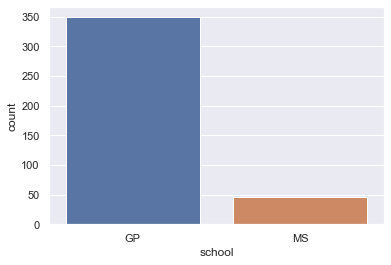

Процент пропусков: 0.0%

Столбец sex
Распределение признака:


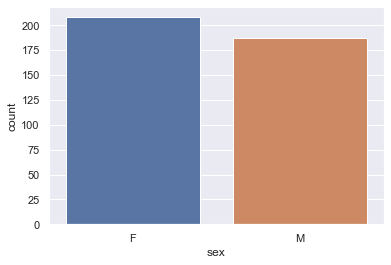

Процент пропусков: 0.0%

Столбец age
Распределение признака:


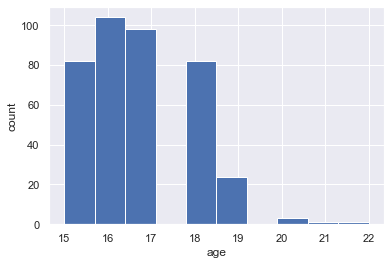

Процент пропусков: 0.0%

Столбец address
Распределение признака:


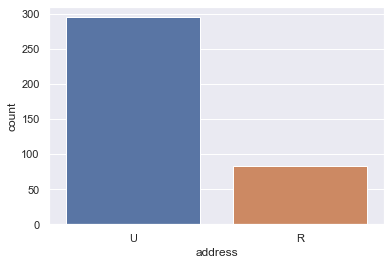

Процент пропусков: 4.3%

Столбец famsize
Распределение признака:


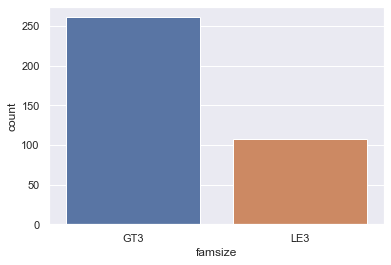

Процент пропусков: 6.84%

Столбец Pstatus
Распределение признака:


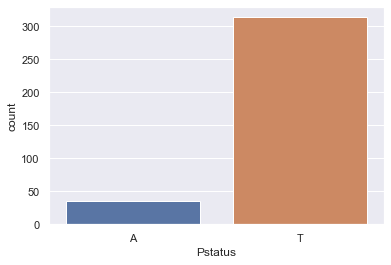

Процент пропусков: 11.39%

Столбец Medu
Распределение признака:


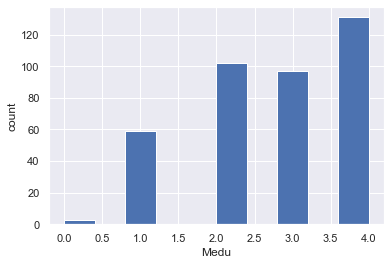

Процент пропусков: 0.76%

Столбец Fedu
Распределение признака:


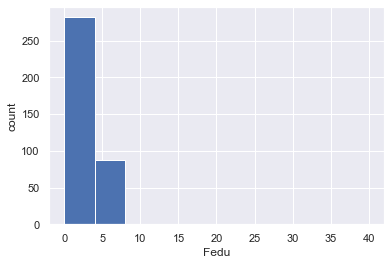

Найдены выбросы:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


Процент пропусков: 6.08%

Столбец Mjob
Распределение признака:


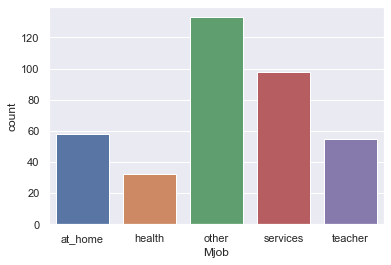

Процент пропусков: 4.81%

Столбец Fjob
Распределение признака:


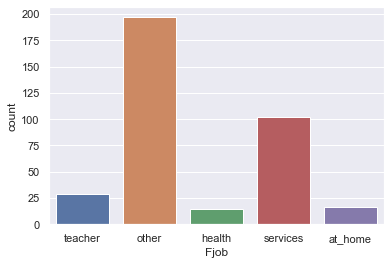

Процент пропусков: 9.11%

Столбец reason
Распределение признака:


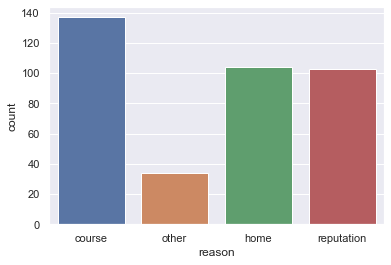

Процент пропусков: 4.3%

Столбец guardian
Распределение признака:


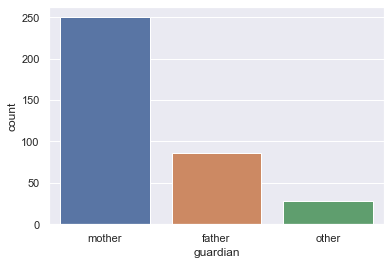

Процент пропусков: 7.85%

Столбец traveltime
Распределение признака:


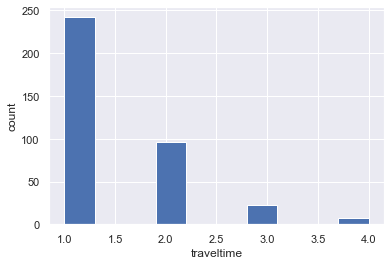

Процент пропусков: 7.09%

Столбец studytime
Распределение признака:


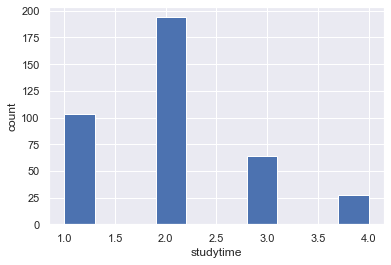

Процент пропусков: 1.77%

Столбец failures
Распределение признака:


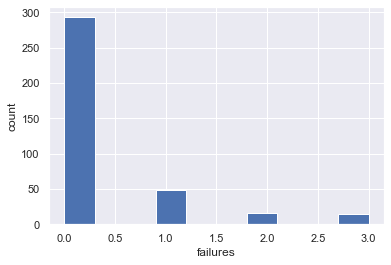

Процент пропусков: 5.57%

Столбец schoolsup
Распределение признака:


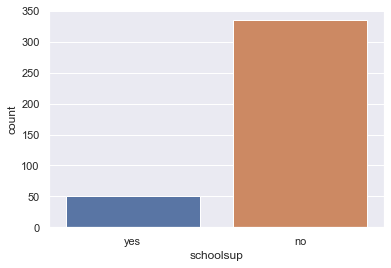

Процент пропусков: 2.28%

Столбец famsup
Распределение признака:


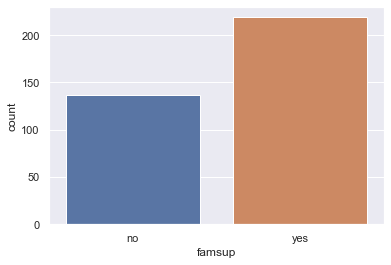

Процент пропусков: 9.87%

Столбец paid
Распределение признака:


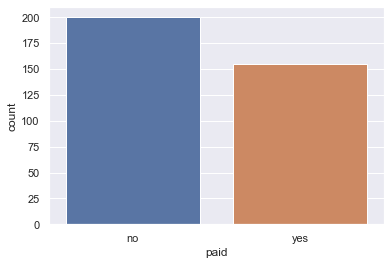

Процент пропусков: 10.13%

Столбец activities
Распределение признака:


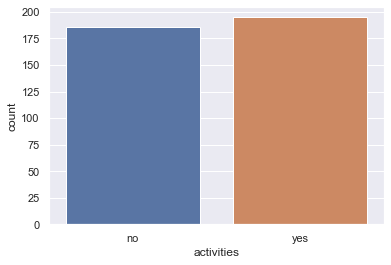

Процент пропусков: 3.54%

Столбец nursery
Распределение признака:


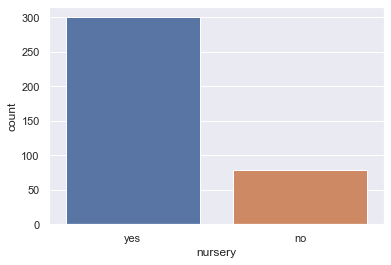

Процент пропусков: 4.05%

Столбец studytime, granular
Распределение признака:


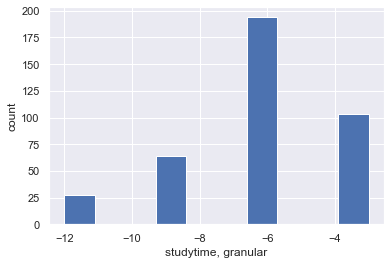

Процент пропусков: 1.77%

Столбец higher
Распределение признака:


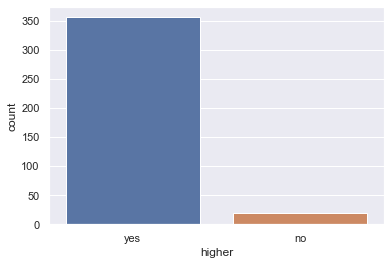

Процент пропусков: 5.06%

Столбец internet
Распределение признака:


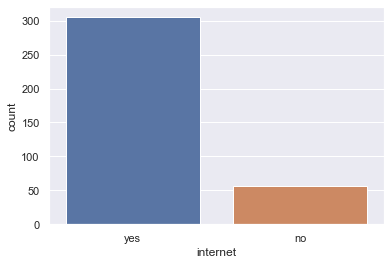

Процент пропусков: 8.61%

Столбец romantic
Распределение признака:


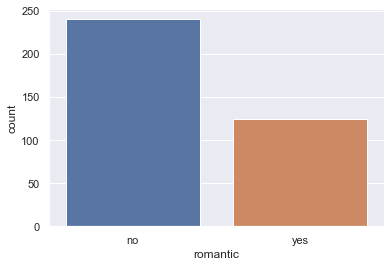

Процент пропусков: 7.85%

Столбец famrel
Распределение признака:


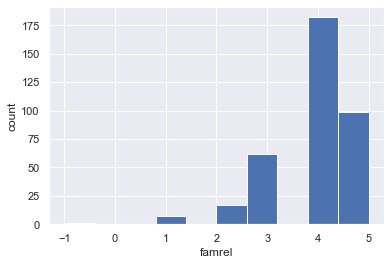

Найдены выбросы:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,-3.0,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


Процент пропусков: 6.84%

Столбец freetime
Распределение признака:


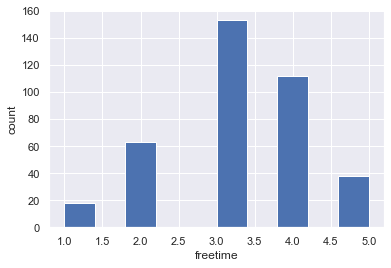

Процент пропусков: 2.78%

Столбец goout
Распределение признака:


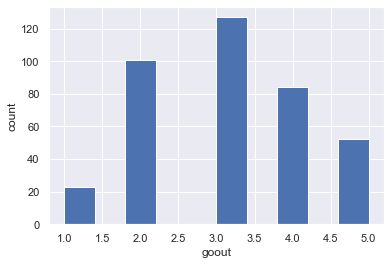

Процент пропусков: 2.03%

Столбец health
Распределение признака:


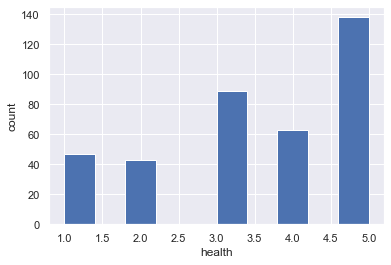

Процент пропусков: 3.8%

Столбец absences
Распределение признака:


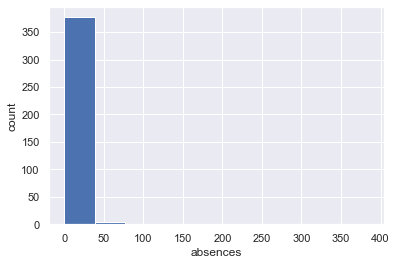

Процент пропусков: 3.04%

Столбец score
Распределение признака:


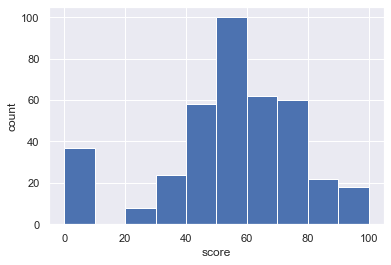

Процент пропусков: 1.52%



In [6]:
first_look('school')
first_look('sex')
first_look('age', boundaries=(15, 22))
first_look('address')
first_look('famsize')
first_look('Pstatus')
first_look('Medu', boundaries=(0,4))
first_look('Fedu', boundaries=(0,4))
first_look('Mjob')
first_look('Fjob')
first_look('reason')
first_look('guardian')
first_look('traveltime', boundaries=(1,4))
first_look('studytime', boundaries=(1,4))
first_look('failures', boundaries=(0,4))
first_look('schoolsup')
first_look('famsup')
first_look('paid')
first_look('activities')
first_look('nursery')
first_look('studytime, granular')
first_look('higher')
first_look('internet')
first_look('romantic')
first_look('famrel', boundaries=(1,5))
first_look('freetime', boundaries=(1,5))
first_look('goout', boundaries=(1,5))
first_look('health', boundaries=(1,5))
first_look('absences')
first_look('score', boundaries=(0, 100)) #из знания о том, что на ЕГЭ от 0 до 100 баллов

В целом, данные в столбцах достаточно числые, доля пропусков варьируется от 1% до 10%. Заполнить выбросы не представляется заполнить на текущий момент.    
В столбцах famrel и Fedu присустсвуют выбросы, которых не должно быть, судя по описанию данных, удалим их:

In [7]:
stud = stud.loc[stud.Fedu.between(0,4)|pd.isnull(stud.Fedu)]
stud = stud.loc[stud.famrel.between(1,5)|pd.isnull(stud.famrel)]

Также видно, что распределение признака absences выглядит странно, давайте посмотрим на него внимательнее:

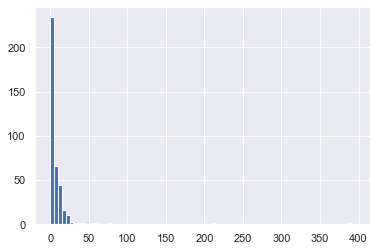

In [8]:
stud.loc[:, 'absences'].hist(bins=list(range(0,400,5)))

Посмотрим на то, что подпапает под категорию выбросов согласно методу, осованному на интерквартильном расстоянии:

In [9]:
perc25 = stud.absences.quantile(0.25)
perc75 = stud.absences.quantile(0.75)
IQR = perc75 - perc25
print('25-й перцентиль:', perc25)
print('75-й перцентиль:', perc75)
print('IQR:', IQR)

IQR = perc75 - perc25
stud.loc[~stud.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR), 'absences']

25-й перцентиль: 0.0
75-й перцентиль: 8.0
IQR: 8.0


24       NaN
40      25.0
74      54.0
101      NaN
103     26.0
120      NaN
129      NaN
150      NaN
172      NaN
183     56.0
198     24.0
205     28.0
215      NaN
216     22.0
222    385.0
227      NaN
254      NaN
260     21.0
265      NaN
270      NaN
276     75.0
277     22.0
280     30.0
307     38.0
313     22.0
315     40.0
320     23.0
352      NaN
390    212.0
Name: absences, dtype: float64

Видно, что присутствуют выбросы, которых физически не могло быть (212 и 385), так как учебныз дней в году меньше. Однако присутствуют и просто экстремальные значения.  
Хотя метод IQR и показывает, что выбросами являются все значения, больше 20, в распределении достаточно много значений, которые < 30 и при этом они выглядят достаточно реально. Давайте оставим их тоже.

In [15]:
stud = stud.loc[stud.absences.between(perc25 - 1.5*IQR, 30)|pd.isnull(stud.absences)]

Посмотрим на распределение признака теперь:

Столбец absences
Распределение признака:


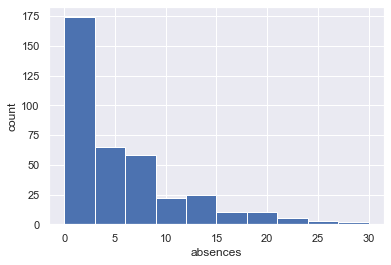

Процент пропусков: 3.11%



In [16]:
first_look('absences')

### 3. Корреляционный анализ

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


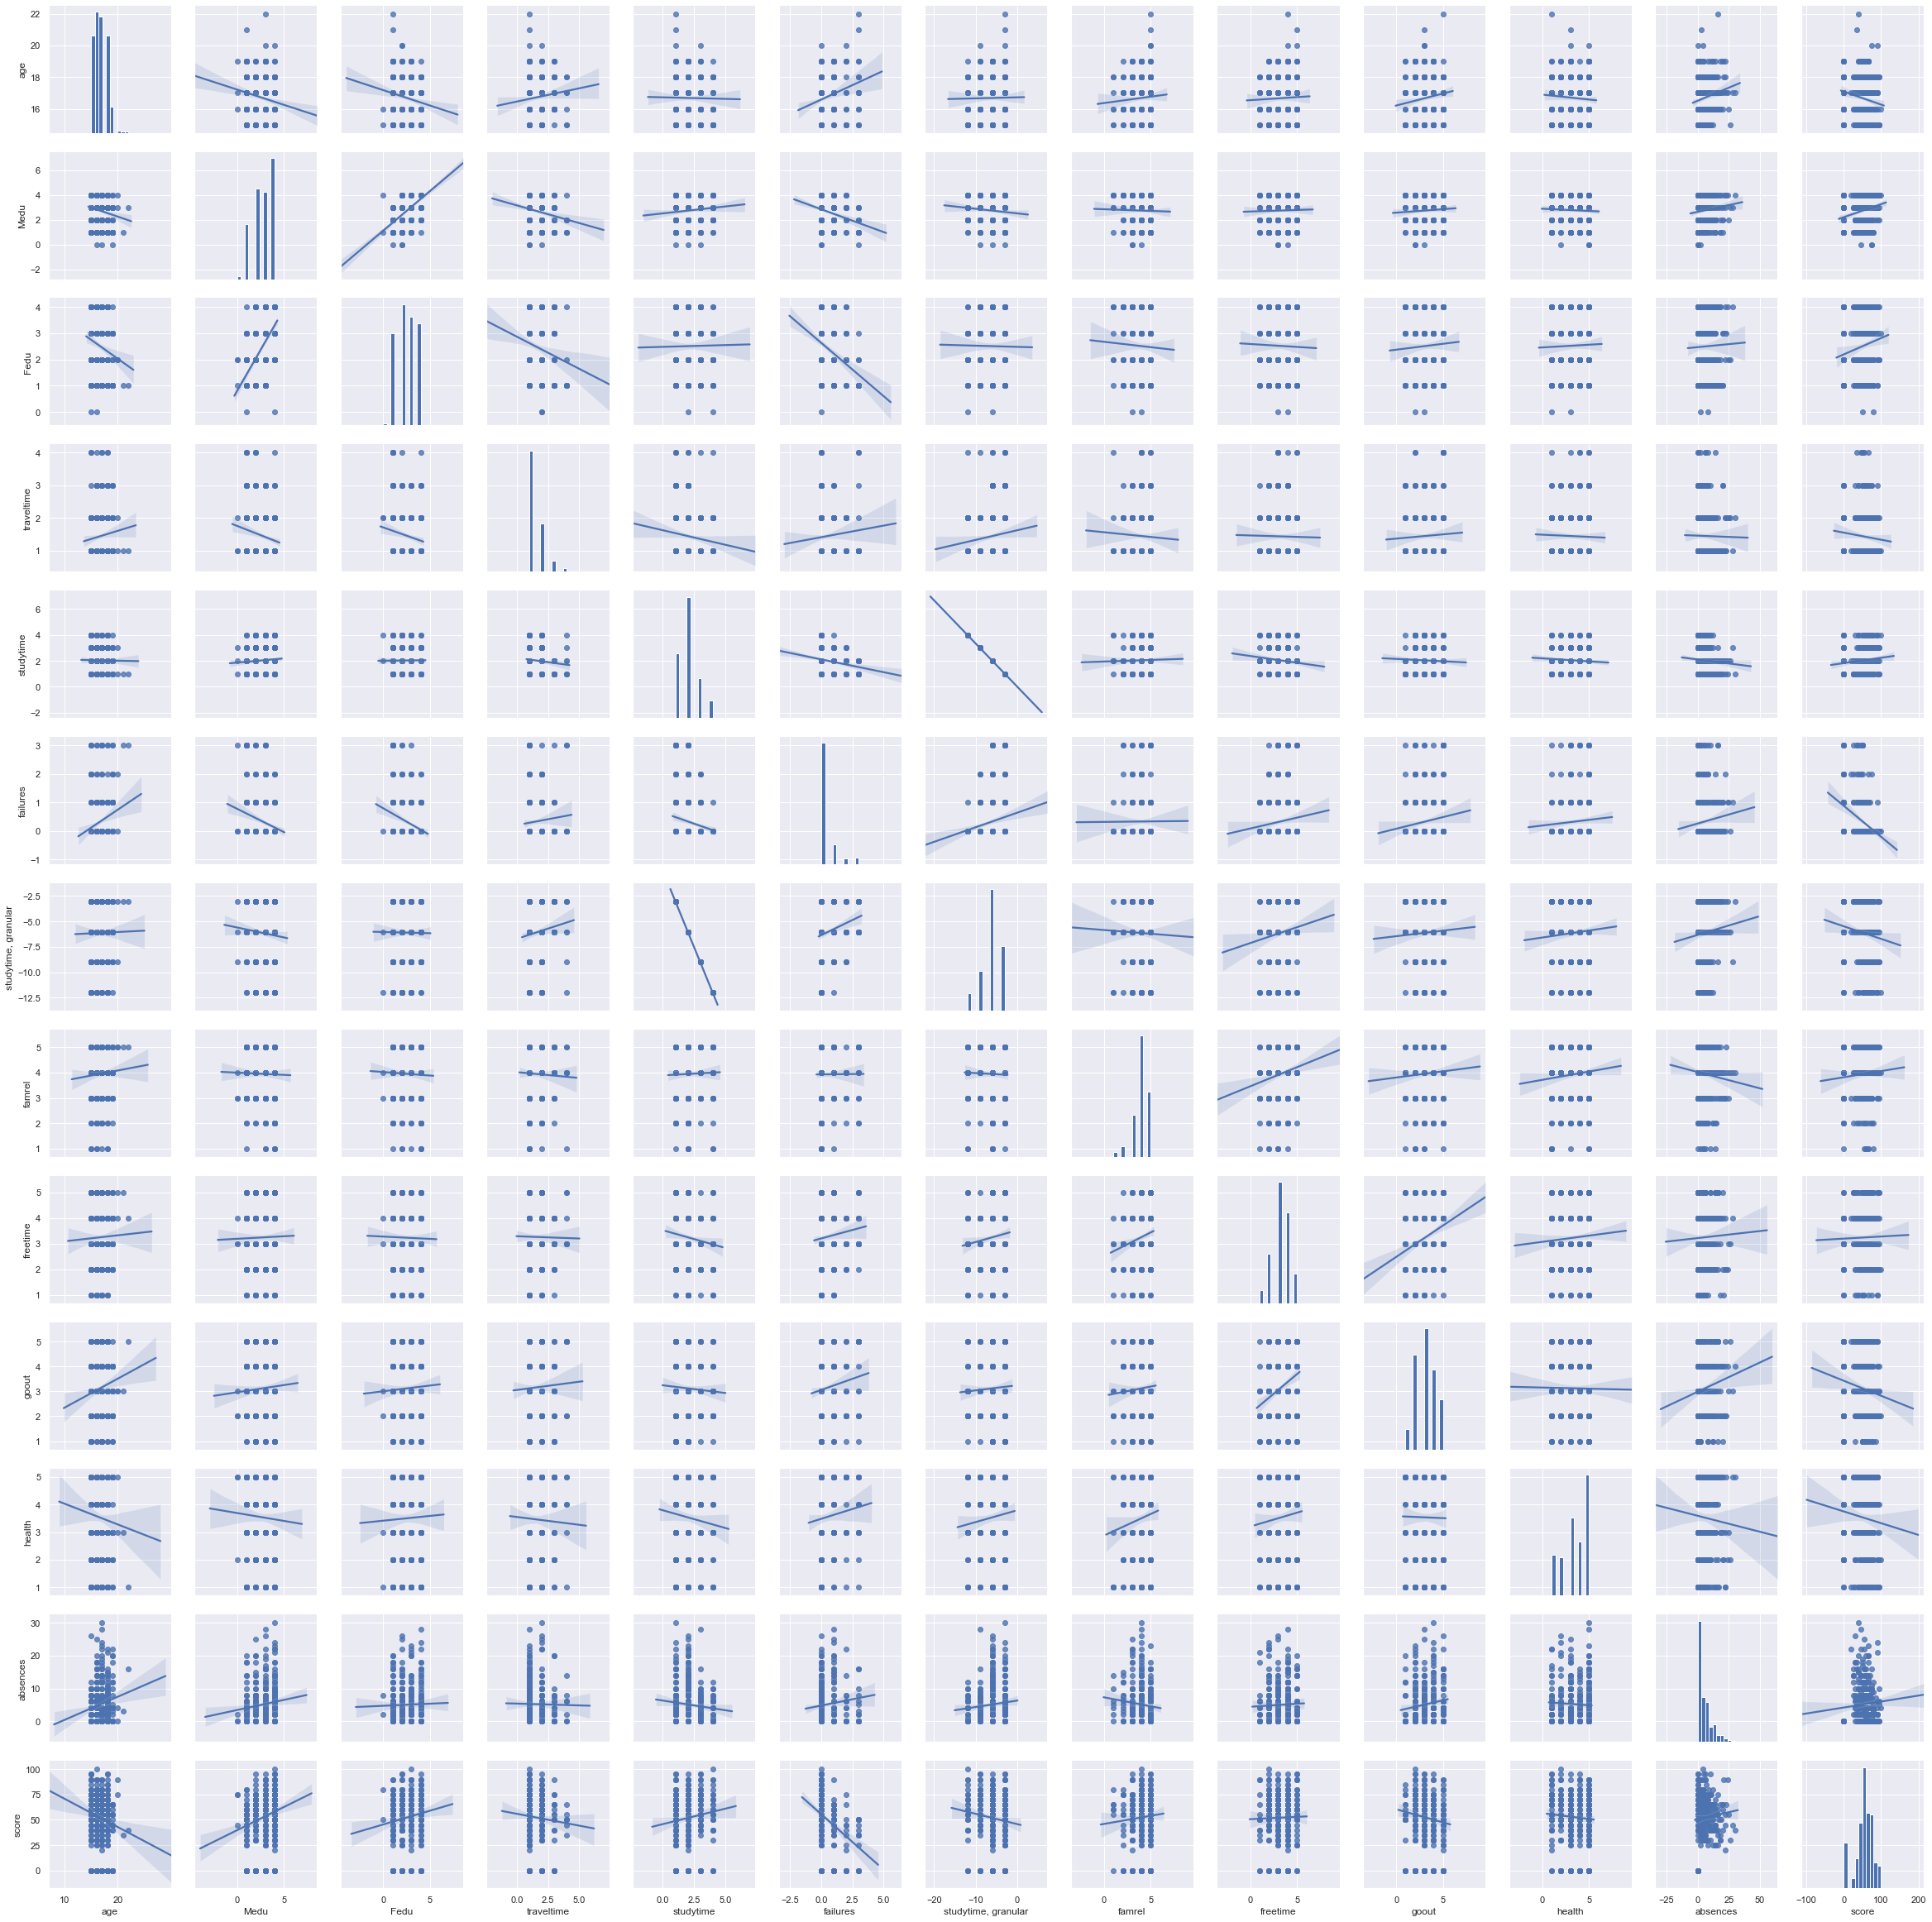

In [17]:
sns.pairplot(stud, kind = 'reg')

In [18]:
stud.corr()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.168372,-0.167669,0.091799,-0.012992,0.214234,0.012992,0.056880,0.030078,0.133192,-0.068302,0.153297,-0.151937
Medu,-0.168372,1.000000,0.631001,-0.179412,0.085039,-0.244731,-0.085039,-0.021766,0.022284,0.056745,-0.045072,0.116053,0.219208
Fedu,-0.167669,0.631001,1.000000,-0.157551,0.010353,-0.275795,-0.010353,-0.033765,-0.020024,0.045484,0.026822,0.024211,0.130248
traveltime,0.091799,-0.179412,-0.157551,1.000000,-0.109110,0.076463,0.109110,-0.036574,-0.012500,0.041531,-0.027764,-0.013083,-0.071457
studytime,-0.012992,0.085039,0.010353,-0.109110,1.000000,-0.173969,-1.000000,0.025719,-0.119867,-0.047334,-0.076607,-0.085330,0.112301
failures,0.214234,-0.244731,-0.275795,0.076463,-0.173969,1.000000,0.173969,0.004264,0.100327,0.120413,0.075043,0.097910,-0.344623
"studytime, granular",0.012992,-0.085039,-0.010353,0.109110,-1.000000,0.173969,1.000000,-0.025719,0.119867,0.047334,0.076607,0.085330,-0.112301
famrel,0.056880,-0.021766,-0.033765,-0.036574,0.025719,0.004264,-0.025719,1.000000,0.166748,0.059976,0.101090,-0.084033,0.062638
freetime,0.030078,0.022284,-0.020024,-0.012500,-0.119867,0.100327,0.119867,0.166748,1.000000,0.278153,0.069803,0.031681,0.019512
goout,0.133192,0.056745,0.045484,0.041531,-0.047334,0.120413,0.047334,0.059976,0.278153,1.000000,-0.011418,0.124583,-0.125179


Колонка studytime, granular дублирует колонку studytime, к тому же её нет в описании признаков. Уберём её из датасета:

In [19]:
stud.drop('studytime, granular', axis = 1, inplace = True)

Из колонок, которые коррелируют с итоговыми баллами на ЕГЭ, выберем для построения модели наиболее коррелирующие (модуль коэффициента более 0.1). Это колонки age, Medu, Fedu, studytime, failures, goout. Уберём другие колонки из рассмотрения:

In [20]:
stud.drop(['traveltime', 'famrel', 'freetime', 'health', 'absences'], axis = 1, inplace=True)

Интересно, что состояние здоровья, пропуски, время до школы, отношения в семье, а также количество свободного времени после школы практически не коррелируют с успешностью на ЕГЭ. 

### 4.  Анализ номинативных переменных

Напишем функцию, которая для номинативных переменных покажет распределение баллов в зависимости от признака, а также покажет статистическую значимость этих различий.

In [28]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386 entries, 0 to 394
Data columns (total 24 columns):
school        386 non-null object
sex           386 non-null object
age           386 non-null int64
address       369 non-null object
famsize       359 non-null object
Pstatus       345 non-null object
Medu          383 non-null float64
Fedu          362 non-null float64
Mjob          367 non-null object
Fjob          350 non-null object
reason        369 non-null object
guardian      356 non-null object
studytime     379 non-null float64
failures      364 non-null float64
schoolsup     377 non-null object
famsup        349 non-null object
paid          346 non-null object
activities    372 non-null object
nursery       370 non-null object
higher        366 non-null object
internet      352 non-null object
romantic      355 non-null object
goout         378 non-null float64
score         380 non-null float64
dtypes: float64(6), int64(1), object(17)
memory usage: 85.4+ KB


In [23]:
def nominative_analysis(col):
    if stud.loc[:, col].dtypes == np.dtype('O'): # Проверка на строковый тип данных
        print('Столбец', col)
        print('Распределение баллов по значениям признака:')
        fig, ax = plt.subplots(figsize = (14, 4))
        sns.boxplot(x=col, y='score', 
                    data=stud,
                   ax=ax)
        plt.xticks(rotation=45)
        ax.set_title('Boxplot for ' + col)
        plt.show()
        permutations_all = list(combinations(stud.loc[:, col].dropna().unique(), 2))
        for perm in permutations_all:
            if ttest_ind(stud.loc[stud.loc[:, col] == perm[0], 'score'].dropna(), 
                            stud.loc[stud.loc[:, col] == perm[1], 'score'].dropna()).pvalue \
                <= 0.05/len(permutations_all): # Учли поправку Бонферони
                print('Найдены статистически значимые различия для колонки', col)
                break
        print('----------------------------------')
        print()

Столбец school
Распределение баллов по значениям признака:


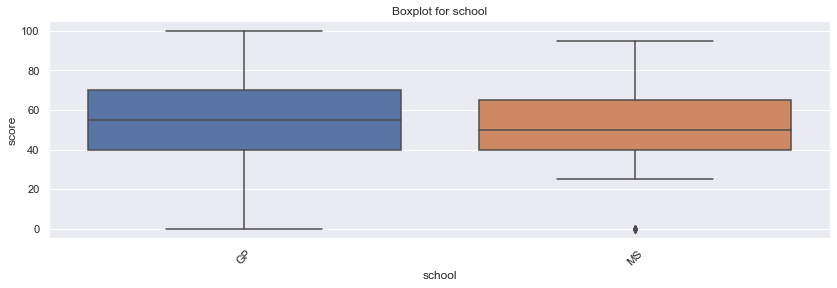

----------------------------------

Столбец sex
Распределение баллов по значениям признака:


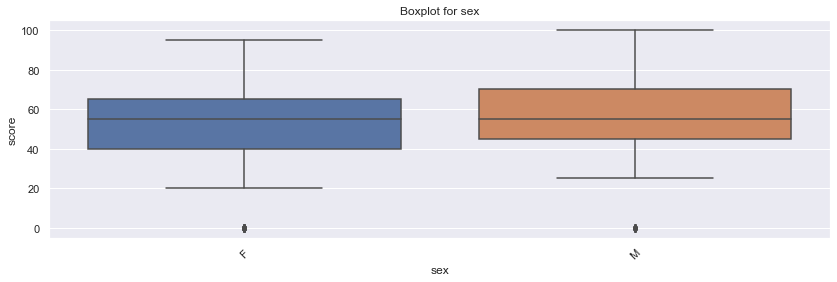

Найдены статистически значимые различия для колонки sex
----------------------------------

Столбец address
Распределение баллов по значениям признака:


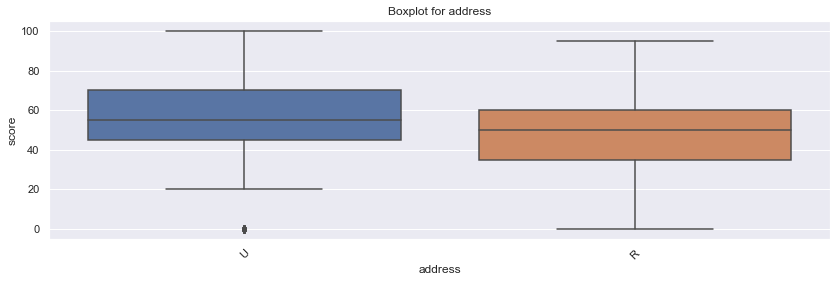

Найдены статистически значимые различия для колонки address
----------------------------------

Столбец famsize
Распределение баллов по значениям признака:


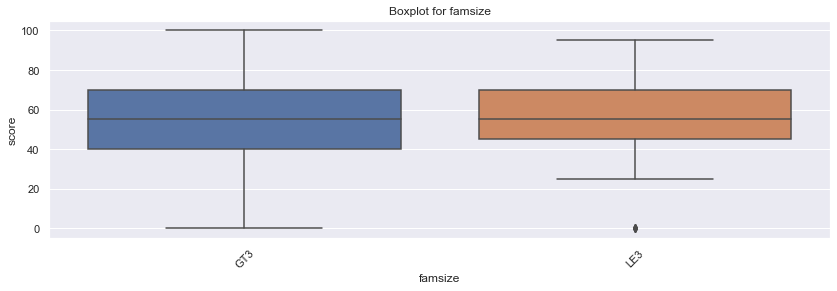

----------------------------------

Столбец Pstatus
Распределение баллов по значениям признака:


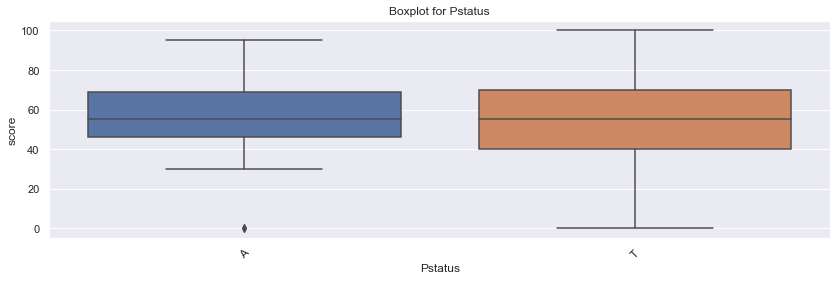

----------------------------------

Столбец Mjob
Распределение баллов по значениям признака:


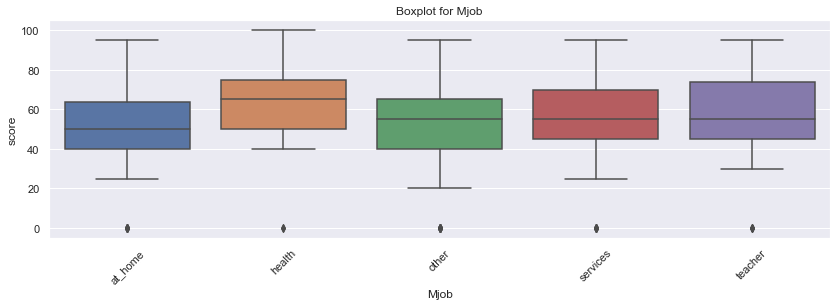

Найдены статистически значимые различия для колонки Mjob
----------------------------------

Столбец Fjob
Распределение баллов по значениям признака:


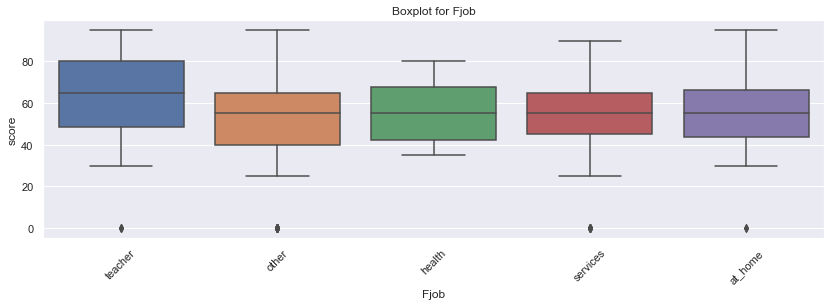

----------------------------------

Столбец reason
Распределение баллов по значениям признака:


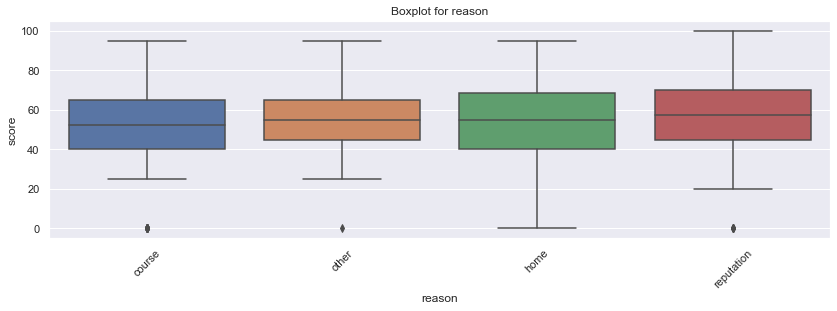

----------------------------------

Столбец guardian
Распределение баллов по значениям признака:


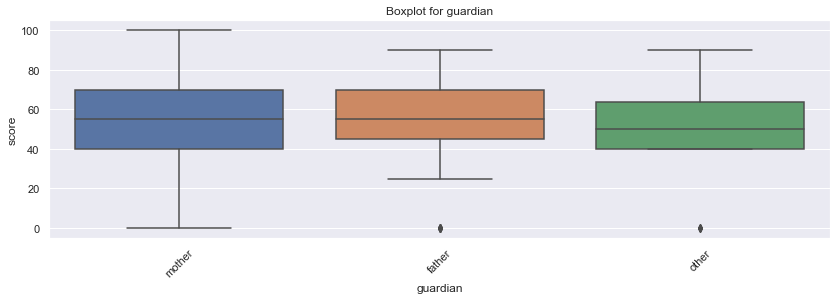

----------------------------------

Столбец schoolsup
Распределение баллов по значениям признака:


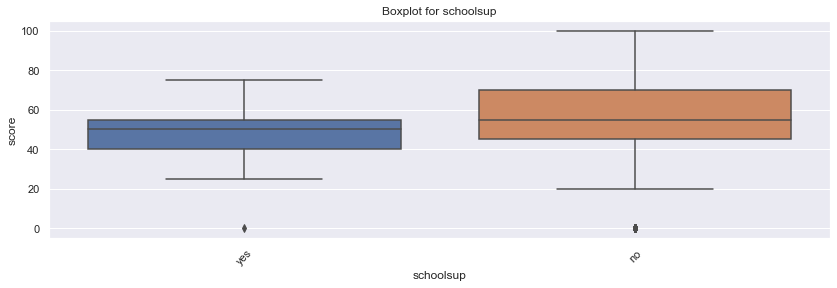

Найдены статистически значимые различия для колонки schoolsup
----------------------------------

Столбец famsup
Распределение баллов по значениям признака:


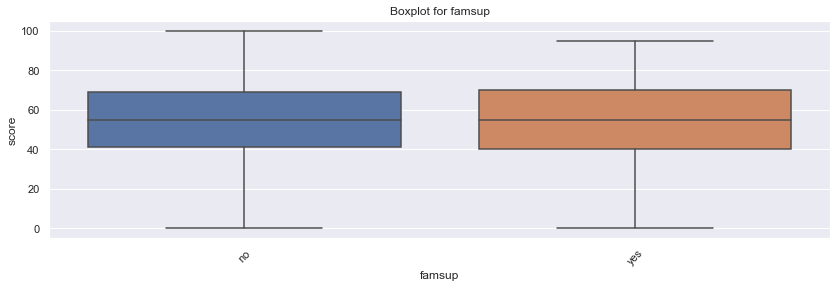

----------------------------------

Столбец paid
Распределение баллов по значениям признака:


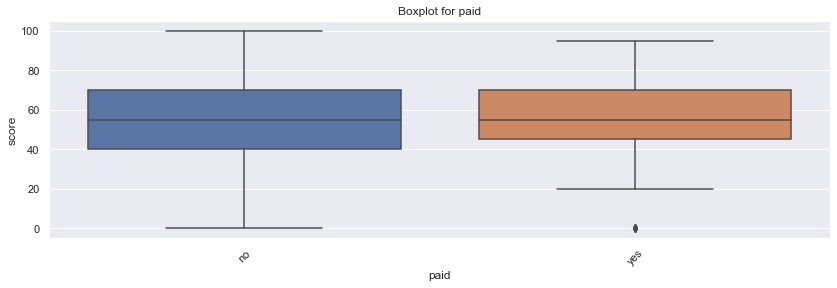

Найдены статистически значимые различия для колонки paid
----------------------------------

Столбец activities
Распределение баллов по значениям признака:


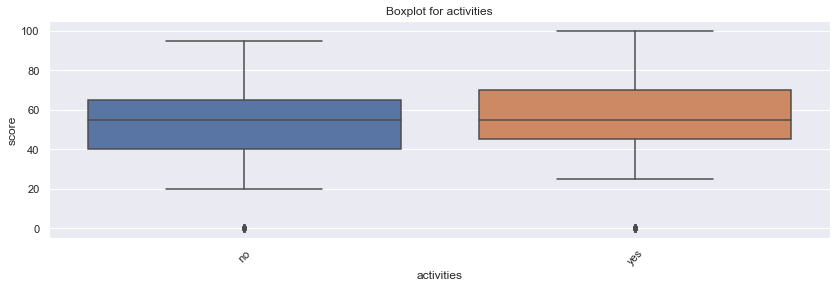

----------------------------------

Столбец nursery
Распределение баллов по значениям признака:


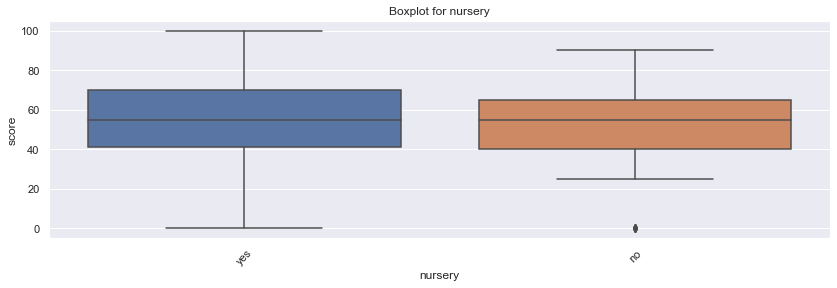

----------------------------------

Столбец higher
Распределение баллов по значениям признака:


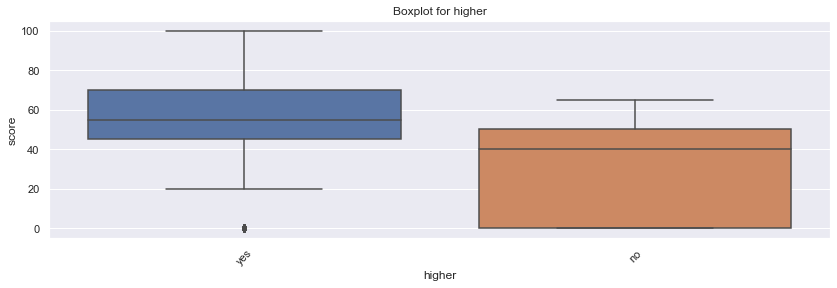

Найдены статистически значимые различия для колонки higher
----------------------------------

Столбец internet
Распределение баллов по значениям признака:


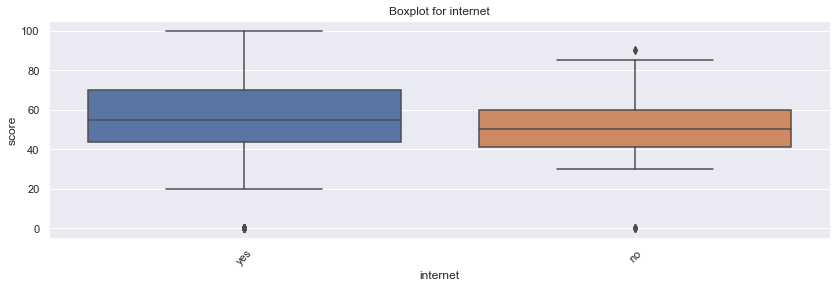

----------------------------------

Столбец romantic
Распределение баллов по значениям признака:


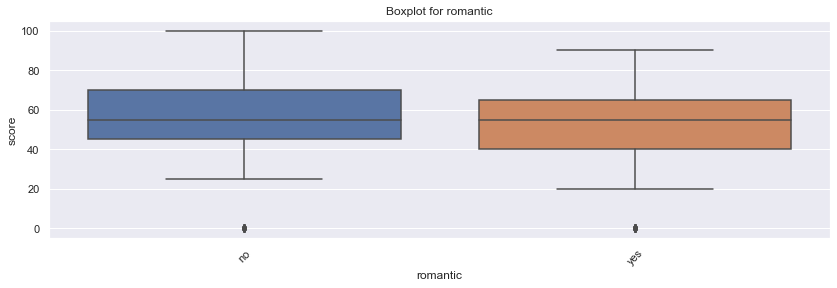

Найдены статистически значимые различия для колонки romantic
----------------------------------



In [24]:
for col in stud.columns:
    nominative_analysis(col)

Значимо отличаются распределения баллов для колонок sex, address, Mjob, schoolsup, paid, higher и romantic. Исключим остальные столбцы:

In [17]:
stud.drop(['school', 'famsize', 'Pstatus', 'Fjob', 'reason', 'guardian', 'famsup', 'activities',
          'nursery', 'internet'], axis = 1, inplace = True)

Интересно, что работа матери влияет на успешность на ЕГЭ, а работа отца - нет. 

Посмотрим, какие данные у нас остались для построения модели после EDA:

In [18]:
stud.head()

,sex,age,address,Medu,Fedu,Mjob,studytime,failures,schoolsup,paid,higher,romantic,goout,score
0,F,18,U,4.0,4.0,at_home,2.0,0.0,yes,no,yes,no,4.0,30.0
1,F,17,U,1.0,1.0,at_home,2.0,0.0,no,no,yes,no,3.0,30.0
2,F,15,U,1.0,1.0,at_home,2.0,3.0,yes,NaN,yes,NaN,2.0,50.0
3,F,15,U,4.0,2.0,health,3.0,0.0,no,yes,yes,yes,2.0,75.0
4,F,16,U,3.0,3.0,other,2.0,0.0,no,yes,yes,no,2.0,50.0


### 5. Выводы

* Почти во всех колонках, кроме school, sex, age, присутствуют пустые значения. Их доля варьируется от 1 до 10 процентов. Заполнить выбросы на текущем этапе не представляется возможным. 
* Выбросы, обусловленные некачественным сбором данных, найдены в столбцах Fedu, famrel. В столбце absences выбросы, похоже, обусловлены как некачественным сбором данных (значения больше 200), так и экстремальными количествами пропусков (например, 53). 
* Состояние здоровья, пропуски, время до школы, отношения в семье, а также количество свободного времени после школы практически не коррелируют с успешностью на ЕГЭ. 
* Работа матери влияет на успешность на ЕГЭ, а работа отца - нет. 
* Для дальнейшего построения модели рекомендуется использовать параметры sex, address, Mjob, schoolsup, paid, higher, romantic, age, Medu, Fedu, studytime, failures, goout.  